# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:

# when running in Udacity workspace
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import time
import torch

from collections import deque
from unityagents import UnityEnvironment

from maddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# In Udacity Workspace
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# In local Ubuntu 18.04.2 LTS setup
#env = UnityEnvironment(file_name="/home/m2keyofz/Downloads/Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.20000000298023224
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. Train agent to solve the environment!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# Some common parameters to use
C_EPISODES = 100 # consecutive episodes
PRINT_EVERY = 10
ADD_NOISE = True

NUM_STATES = state_size

In [8]:
# Utility function
def get_actions(states, add_noise):
    action_0 = agent_0.act(states, add_noise)
    action_1 = agent_1.act(states, add_noise)
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [9]:
# MADDPG
def maddpg(n_episodes=2500, max_t=1000):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode

    """
    scores_window = deque(maxlen=C_EPISODES)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    solved = False
    c_states = NUM_STATES * 2 # combine states

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1,c_states))
        
        agent_0.reset()
        agent_1.reset()
        
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, ADD_NOISE)
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,c_states))
            rewards = env_info.rewards
            done = env_info.local_done
            agent_0.step(states, actions, rewards[0], next_states, done, 0)
            agent_1.step(states, actions, rewards[1], next_states, done, 1)
            scores += np.max(rewards)
            states = next_states
            if np.any(done):
                break

        ep_best = np.max(scores)
        scores_window.append(ep_best)
        scores_all.append(ep_best)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if ep_best > best_score:
            best_score = ep_best
            best_episode = i_episode
        
        if i_episode % PRINT_EVERY == 0:
            print('\tEpisode {:0>4d}\tMoving Average: {:.3f}'.format(i_episode, moving_average[-1]))

        if moving_average[-1] >= 0.5: # Reached goal?
            if not solved:
                print('\n\tEnvironment solved in {:d} episodes! \
                \n\tMoving Average: {:.3f} (over past {:d} episodes)\n'.format(
                    i_episode-C_EPISODES, moving_average[-1], C_EPISODES))
                solved = True
                
                torch.save(agent_0.actor_local.state_dict(),  'weights/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'weights/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(),  'weights/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'weights/checkpoint_critic_1.pth')
                
            elif ep_best >= best_score:
                torch.save(agent_0.actor_local.state_dict(),  'weights/checkpoint_actor_0.pth')
                torch.save(agent_0.critic_local.state_dict(), 'weights/checkpoint_critic_0.pth')
                torch.save(agent_1.actor_local.state_dict(), 'weights/checkpoint_actor_1.pth')
                torch.save(agent_1.critic_local.state_dict(), 'weights/checkpoint_critic_1.pth')
            elif (i_episode-best_episode) >= 200:
                print('\n\tTraining stopped: best score stale for 200 episodes.')
                break
                
            else:
                continue
    return scores_all, moving_average


In [10]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

#### Train Model!

In [11]:
start = time.time()

In [12]:
# Hyper-parameters used (taken from maddpg_agent.py)

# BUFFER_SIZE = int(1e6)  # replay buffer size
# BATCH_SIZE = 128        # minibatch size
# LR_ACTOR = 1e-3         # learning rate of the actor
# LR_CRITIC = 1e-3        # learning rate of the critic
# WEIGHT_DECAY = 0        # L2 weight decay
# LEARN_EVERY = 10        # learning timestep interval
# LEARN_NUM = 5           # number of learning passes
# GAMMA = 0.99            # discount factor
# TAU = 8e-3              # for soft update of target parameters
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
# OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
# EPS_START = 5.0         # initial value for epsilon in noise decay process in Agent.act()
# EPS_EP_END = 300        # episode to end the noise decay process
# EPS_FINAL = 0           # final value for epsilon after decay

In [13]:
scores, avgs = maddpg()

# Episode 0730	Moving Average: 0.467
# Environment solved in 634 episodes!                 
# Moving Average: 0.506 (over past 100 episodes)

	Episode 0010	Moving Average: 0.000
	Episode 0020	Moving Average: 0.000
	Episode 0030	Moving Average: 0.000
	Episode 0040	Moving Average: 0.003
	Episode 0050	Moving Average: 0.004
	Episode 0060	Moving Average: 0.007
	Episode 0070	Moving Average: 0.007
	Episode 0080	Moving Average: 0.008
	Episode 0090	Moving Average: 0.007
	Episode 0100	Moving Average: 0.008
	Episode 0110	Moving Average: 0.008
	Episode 0120	Moving Average: 0.010
	Episode 0130	Moving Average: 0.011
	Episode 0140	Moving Average: 0.015
	Episode 0150	Moving Average: 0.016
	Episode 0160	Moving Average: 0.015
	Episode 0170	Moving Average: 0.015
	Episode 0180	Moving Average: 0.016
	Episode 0190	Moving Average: 0.017
	Episode 0200	Moving Average: 0.016
	Episode 0210	Moving Average: 0.017
	Episode 0220	Moving Average: 0.018
	Episode 0230	Moving Average: 0.019
	Episode 0240	Moving Average: 0.015
	Episode 0250	Moving Average: 0.013
	Episode 0260	Moving Average: 0.013
	Episode 0270	Moving Average: 0.014
	Episode 0280	Moving Average

In [17]:
end = time.time()
elapsed = (end - start) / 60.0
print("Elapsed: {0:3.2f} mins.".format(elapsed))

Elapsed: 17.22 mins.


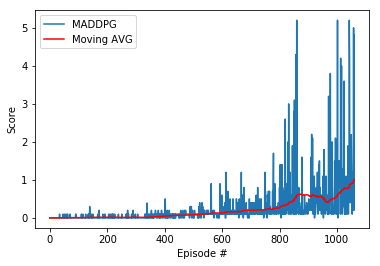

In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [16]:
env.close()